In [3]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:,.3f}'.format

### 주가지수보다 더 좋은 수익율을 자주 보여준다.    

In [4]:
mdl_data = pd.read_pickle('mdl_data.pkl')
mdl_data.head().style.set_table_attributes('style="font-size: 10px"')

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market,close_r1,close_r2,close_r3,close_r4,close_r5,max_close
2021-01-05,2270,2285,2200,2250,410263,-0.004425,060310,3S,1.008326,0.995575,0,1.017778,1.017778,0.997778,0.966667,0.971111,1.017778
2021-01-06,2225,2310,2215,2290,570349,0.017778,060310,3S,0.995567,1.017778,1,1.000000,0.980349,0.949782,0.954148,0.949782,1.000000
2021-01-07,2290,2340,2240,2290,519777,0.000000,060310,3S,1.007612,1.000000,0,0.980349,0.949782,0.954148,0.949782,0.958515,0.980349
2021-01-08,2300,2315,2225,2245,462568,-0.019651,060310,3S,0.998918,0.980349,0,0.968820,0.973274,0.968820,0.977728,0.973274,0.977728
2021-01-11,2230,2275,2130,2175,409057,-0.031180,060310,3S,0.988702,0.968820,0,1.004598,1.000000,1.009195,1.004598,1.002299,1.009195


<br> 이전 장에서 일봉 데이터에 KOSDAQ 주가지수 데이터를 추가한 후, 주가지수 수익율이 1 보다 작은 날, 종목 수익율이 1 보다 크면 win_market 이라는 변수에 1 을 담아 두도록 했습니다. win_market 의 과거 60일 동안 합계와 미래 수익율과의 관계를 보겠습니다. 별도로 주가지수 수익률 대비 종목 수익율의 비율을 새로운 변수로 만들어, 미래 수익율과의 상관관계도 볼 수 있도록 하겠습니다.

In [5]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_h5 = pd.DataFrame()

for code in kosdaq_list['code']:
    
    # 종목별 처리
    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    
    # 과거 60일 win_market 누적 합
    data['num_win_market'] = data['win_market'].rolling(60).sum() # 주가지수 수익율이 1 보다 작을 때, 종목 수익율이 1 보다 큰 날 수
    data['pct_win_market'] = (data['return']/data['kosdaq_return']).rolling(60).mean() # 주가지수 수익율 대비 종목 수익율
        
    
        # 고가, 저가, 종가 수익율
    for i in [1,2,3,4,5]:

        data['high_r' + str(i)] = data['high'].shift(-1*i)/data['close']      
        data['low_r' + str(i)] = data['low'].shift(-1*i)/data['close']   
        data['close_r' + str(i)] = data['close'].shift(-1*i)/data['close']    
        
    data['max_close']  = data[['close_r1','close_r2','close_r3','close_r4','close_r5']].max(axis=1) # 5 영업일 종가 수익율 중 최고 값
    data.dropna(subset=['num_win_market','close_r1','close_r2','close_r3','close_r4','close_r5'], inplace=True) # missing 이 있는 행은 제거   
 
    data_h5 = pd.concat([data, data_h5], axis=0)

data_h5.to_pickle('data_h5.pkl')    
data_h5.head()    

,open,high,low,close,volume,change,code,name,kosdaq_return,return,...,high_r1,low_r1,high_r2,low_r2,high_r3,low_r3,high_r4,low_r4,high_r5,low_r5
2021-04-01,13100,13650,13100,13400,194185,0.023,238490,힘스,1.010,1.023,...,1.019,0.993,1.030,1.000,1.037,1.007,1.041,1.007,1.049,1.026
2021-04-02,13500,13650,13300,13500,136673,0.007,238490,힘스,1.004,1.007,...,1.022,0.993,1.030,1.000,1.033,1.000,1.041,1.019,1.030,1.015
2021-04-05,13600,13800,13400,13700,219062,0.015,238490,힘스,1.000,1.015,...,1.015,0.985,1.018,0.985,1.026,1.004,1.015,1.000,1.011,0.989
2021-04-06,13800,13900,13500,13650,135914,-0.004,238490,힘스,0.999,0.996,...,1.022,0.989,1.029,1.007,1.018,1.004,1.015,0.993,1.007,0.996
2021-04-07,13700,13950,13500,13950,195408,0.022,238490,힘스,1.005,1.022,...,1.007,0.986,0.996,0.982,0.993,0.971,0.986,0.975,1.022,0.971


<br> 예상한 바와 같이 주가지수가 빠질 때, 수익율이 좋았던 종목들은 미래 수익율이 좋게 나타났습니다. 주가지수 수익율 대비 종목수익율의 경우는 아주 크거나 작을 때 수익율이 좋게 나타났습니다.

num_win_market
(-0.001, 4.0]   1.022
(4.0, 5.0]      1.031
(5.0, 6.0]      1.031
(6.0, 7.0]      1.032
(7.0, 8.0]      1.032
(8.0, 9.0]      1.034
(9.0, 11.0]     1.036
(11.0, 22.0]    1.040
Name: max_close, dtype: float64


<AxesSubplot:xlabel='num_win_market'>

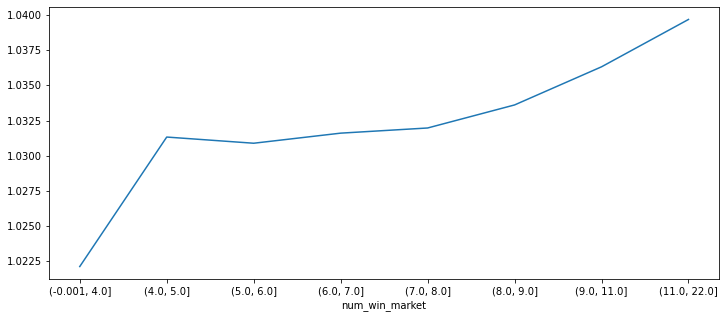

In [6]:
data_h5 = pd.read_pickle('data_h5.pkl')    
ranks = pd.qcut(data_h5['num_win_market'], q=8)
print(data_h5.groupby(ranks)['max_close'].mean())
data_h5.groupby(ranks)['max_close'].mean().plot(figsize=(12,5))

pct_win_market
(0.9747, 0.9964]   1.039
(0.9964, 0.9976]   1.030
(0.9976, 0.9985]   1.026
(0.9985, 0.9992]   1.024
(0.9992, 1.0]      1.025
(1.0, 1.0007]      1.026
(1.0007, 1.0016]   1.028
(1.0016, 1.0029]   1.031
(1.0029, 1.0052]   1.038
(1.0052, 1.0432]   1.049
Name: max_close, dtype: float64


<AxesSubplot:xlabel='pct_win_market'>

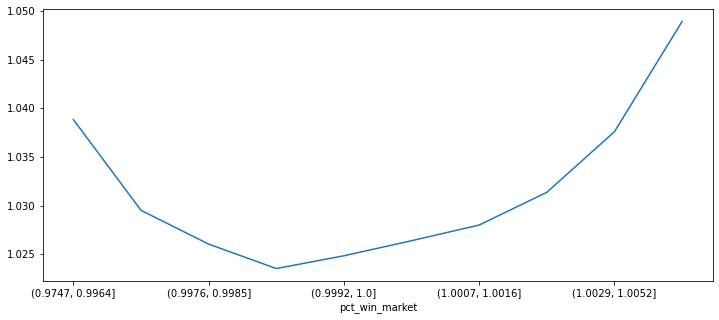

In [7]:
data_h5 = pd.read_pickle('data_h5.pkl')    
ranks = pd.qcut(data_h5['pct_win_market'], q=10)
print(data_h5.groupby(ranks)['max_close'].mean())
data_h5.groupby(ranks)['max_close'].mean().plot(figsize=(12,5))